## Семинар: "Методы оптимизации"

In [21]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [22]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

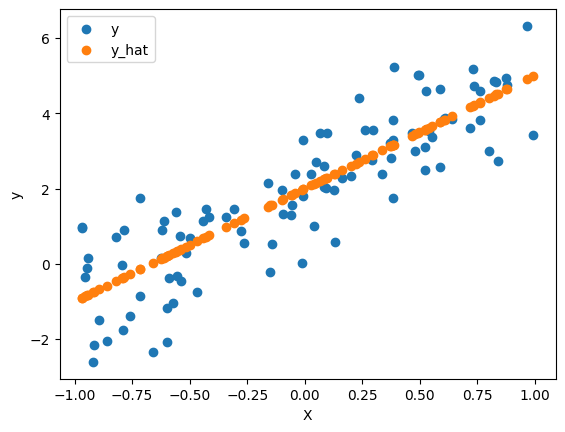

In [23]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

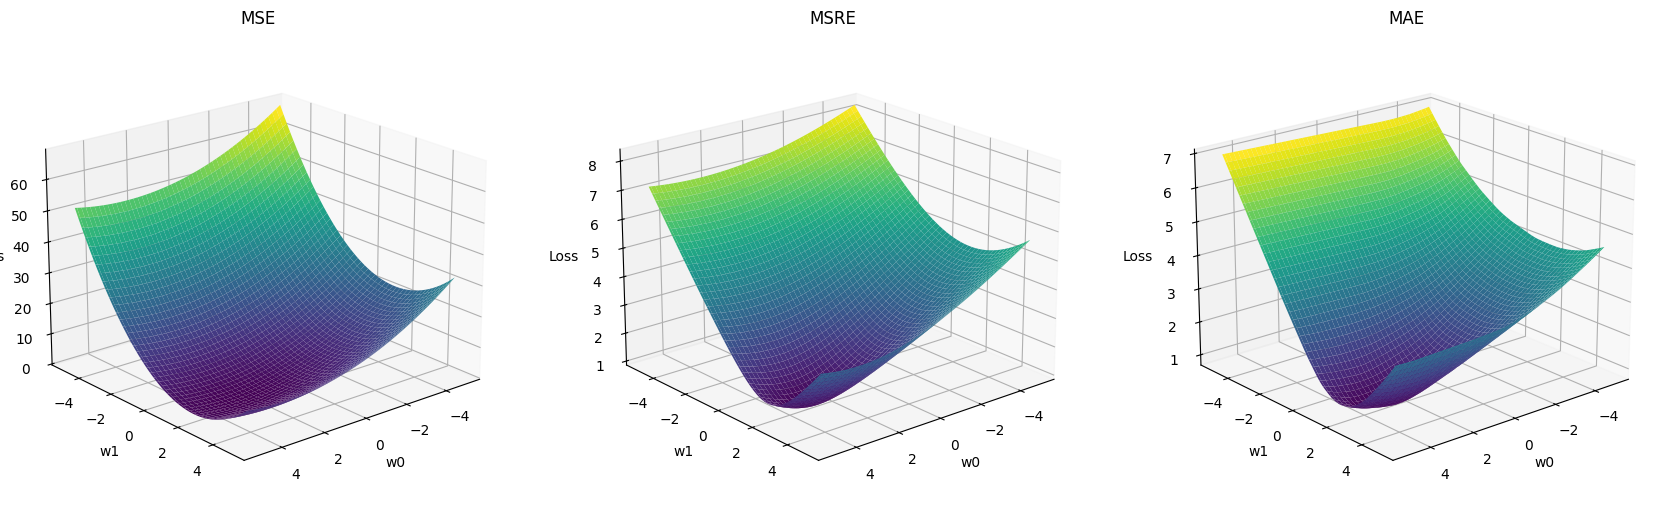

In [24]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [25]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):# - обнужение градиентов у всех параметров
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()# - отсоединение градиента от графа вычислений
                param.grad.zero_()# - обнуление значения градиента

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()# - ошибка, если попытка прямого вызова


In [26]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [27]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [28]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [29]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [30]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [31]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [32]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [35]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [ ]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1400x800', '-pix_fmt', 'rgba', '-framerate', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpkee10td3/temp.m4v']' returned non-zero exit status 255.

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2025-10-07 15:49:48--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-10-07 15:49:48--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [                <=> ]  33.20M  9.62MB/s    in 3.4s    

2025-10-07 15:49:52 (9.62 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Пункт1

In [55]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9,0.999), eps=1e-8, weight_decay=0.0):
        super().__init__(params)
        self.lr = lr
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.eps = eps
        self.weight_decay = weight_decay
        self.momentum = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            grad = p.grad
            if self.weight_decay != 0:
                grad = grad + self.weight_decay * p
            self.momentum[i] = self.beta1 * self.momentum[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad ** 2

            m_hat = self.momentum[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            p.data = p.data - self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)


In [56]:
class AdamW(Adam):
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            grad = p.grad
            if self.weight_decay != 0:
                p.data = p.data * (1 - self.lr * self.weight_decay)
            self.momentum[i] = self.beta1 * self.momentum[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad * grad

            m_hat = self.momentum[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            p.data = p.data - self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

In [57]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Adam', Adam, {'lr': 1e-1}],
        ['AdamW', AdamW, {'lr': 1e-1}]
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/3 [00:00<?, ?it/s]

# Пункт 2

In [ ]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer


    def step(self):
        pass

In [53]:
import math

class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.iter = 0
        self.base_lr = optimizer.lr

    def step(self):
        self.iter += 1
        factor = self.start_factor + (self.end_factor - self.start_factor) * min(1.0, self.iter/self.total_iters)
        self.optimizer.lr = self.base_lr * factor
        #self.optimizer.lr = self.optimizer.lr * factor

class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.iter = 0
        self.base_lr = optimizer.lr

    def step(self):
        self.iter += 1
        factor = self.eta_min + (1 - self.eta_min) * (1 + math.cos(math.pi * self.iter / self.T_max)) / 2
        self.optimizer.lr = self.base_lr * factor


In [36]:
def optimize_function(fn, optim_class, optim_args, start_point, num_iter=50, scheduler_class=None, scheduler_args=None):
    weights = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)
    optimizer = optim_class(params=[weights], **optim_args)
    scheduler = None
    if scheduler_class is not None:
        scheduler = scheduler_class(optimizer, **(scheduler_args or {}))

    points = []
    losses = []

    for i in range(num_iter):
        if hasattr(optimizer, 'pre_step'):
            optimizer.pre_step()

        loss = fn(weights)
        points.append(weights.data.detach().clone())
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [37]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter=50,
    step_skip=1,
    scheduler_class=None,
    scheduler_args=None
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)

    for name, optim_class, args in tqdm(optim_list):
        points, losses = optimize_function(
            loss_func,
            optim_class,
            args,
            start_point,
            num_iter,
            scheduler_class=scheduler_class,
            scheduler_args=scheduler_args
        )

        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)


In [50]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Adam', Adam, {'lr': 1e-1}],
        ['AdamW', AdamW, {'lr': 1e-1}],
    ],
    start_point=[-4, -4],
    num_iter=100,
    scheduler_class=LinearLR,
    scheduler_args={'start_factor': 0.1, 'end_factor': 1.0, 'total_iters': 100}
)



  0%|          | 0/3 [00:00<?, ?it/s]

In [54]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Adam', Adam, {'lr': 1e-1}],
        ['AdamW', AdamW, {'lr': 1e-1}],
    ],
    start_point=[-4, -4],
    num_iter=100,
    scheduler_class=CosineAnnealing,
    scheduler_args={'T_max': 100, 'eta_min': 0.1}
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [58]:
# Fix notebook metadata for GitHub
import json
import numpy as np

def fix_notebook_for_github():
    """Fix widget metadata to make notebook compatible with GitHub"""
    try:
        # Get the notebook content
        from google.colab import _message

        # Request notebook content
        notebook_content = _message.blocking_request('get_notebook', timeout_sec=120)['notebook']

        # Fix metadata
        if 'metadata' in notebook_content:
            if 'widgets' in notebook_content['metadata']:
                # Ensure widgets has state key
                if isinstance(notebook_content['metadata']['widgets'], list):
                    notebook_content['metadata']['widgets'] = {'state': {}}
                elif 'state' not in notebook_content['metadata']['widgets']:
                    notebook_content['metadata']['widgets']['state'] = {}

            # Remove Colab-specific widget config if present
            notebook_content['metadata'].pop('colab', None)

        # Save fixed notebook
        fixed_content = json.dumps(notebook_content, indent=2, ensure_ascii=False)

        # Download fixed notebook
        from google.colab import files
        with open('fixed_notebook.ipynb', 'w', encoding='utf-8') as f:
            f.write(fixed_content)

        files.download('fixed_notebook.ipynb')
        print("✅ Fixed notebook downloaded as 'fixed_notebook.ipynb'")

    except Exception as e:
        print(f"❌ Error: {e}")
        print("Trying alternative method...")
        alternative_fix()

def alternative_fix():
    """Alternative method using IPython"""
    try:
        from IPython.display import Javascript
        display(Javascript('''
            function fixNotebook() {
                var notebook = IPython.notebook;
                if (notebook.metadata.widgets) {
                    if (Array.isArray(notebook.metadata.widgets)) {
                        notebook.metadata.widgets = {state: {}};
                    } else if (!notebook.metadata.widgets.state) {
                        notebook.metadata.widgets.state = {};
                    }
                }
                // Save notebook
                notebook.save_notebook();
                setTimeout(function() {
                    // Trigger download
                    var link = document.createElement('a');
                    link.download = 'fixed_notebook.ipynb';
                    link.href = window.location.href.replace(/view$/, 'download');
                    link.click();
                }, 1000);
            }
            fixNotebook();
        '''))
    except Exception as e:
        print(f"Alternative method also failed: {e}")

# Run the fix
fix_notebook_for_github()

❌ Error: 'notebook'
Trying alternative method...


<IPython.core.display.Javascript object>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here